In [ ]:
#this cell is for all packages installation
!pip install librosa 
!pip install noisereduce

In [2]:
#this cell is for all imports needed
import os
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
import noisereduce as nr
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
#this cell is for all constants and parameters that will be used 
train_path = '/kaggle/input/nuaih-age-capturing-from-speech-signals/Age_Through_Speech/Age_Through_Speech/train.csv'
test_path = '/kaggle/input/nuaih-age-capturing-from-speech-signals/Age_Through_Speech/Age_Through_Speech/test.csv'
audios_path = '/kaggle/input/nuaih-age-capturing-from-speech-signals/Age_Through_Speech/Age_Through_Speech/one_and_multiple/'
sr = 48000

In [4]:
def read_data(file_path=train_path, root_dir=audios_path, verbose=False, split=True):
    df = pd.read_csv(file_path)

    if split:
        # split speakers to train and val
        train_subjects, val_subjects, y_train, y_val = train_test_split(df['Subject'].tolist(),df['Age'].tolist(), test_size=0.2, random_state=12)
    else:
        train_subjects, val_subjects, y_train, y_val = df['Subject'].tolist(), [], df['Age'].tolist(), []

        
    # Dictionary that maps subject to its age
    train_dict = dict(zip(train_subjects, y_train))
    val_dict = dict(zip(val_subjects, y_val))

    train_audio_filenames = []
    val_audio_filenames = []
    test_audio_filenames = []
    y_train = []
    y_val = []

    for audio_filename in np.array(os.listdir(root_dir)):
        subject = int(audio_filename[5:9])
        if subject in train_subjects:
            train_audio_filenames.append(audio_filename)
            y_train.append(train_dict[subject])
        elif subject in val_subjects:
            val_audio_filenames.append(audio_filename)
            y_val.append(val_dict[subject])
        else:
            test_audio_filenames.append(audio_filename)
        
        
    if verbose:
        print('Total Test File: ', len(test_audio_filenames))
        print('Total Train Audio File: ', len(train_audio_filenames))
        print('Total Val Audio File: ', len(val_audio_filenames))
    return train_audio_filenames, val_audio_filenames, test_audio_filenames, y_train, y_val


def get_audios( train_audio_filenames, val_audio_filenames, test_audio_filenames,audios_path,threshold = 20):
    train_data=[]
    val_data=[]
    test_data=[]
    
   
    for file_name in train_audio_filenames:
        y, _ = librosa.load(audios_path+file_name,sr=sr)
        y = nr.reduce_noise(y, sr)
        # remove periods of silence
        yt, index = librosa.effects.trim(y, top_db=threshold)
        train_data.append(yt)
        
    for file_name in val_audio_filenames:
        y, _ = librosa.load(audios_path+file_name,sr=sr)
        y = nr.reduce_noise(y, sr)
        yt, index = librosa.effects.trim(y, top_db=threshold)
        val_data.append(yt)
        
    for file_name in test_audio_filenames:
        y, _ = librosa.load(audios_path+file_name,sr=sr)
        y = nr.reduce_noise(y, sr)
        yt, index = librosa.effects.trim(y, top_db=threshold)
        test_data.append(yt)
        
    return train_data, val_data, test_data  

In [5]:
#this cell is for reading the data set and formating it in a list of numpy audios and age label

# get current time in seconds
start_read_time = time.time()
train_audio_filenames, val_audio_filenames, test_audio_filenames, y_train, y_val = read_data(file_path=train_path,root_dir=audios_path,verbose=True,split=True)
train_data, val_data, test_data = get_audios(train_audio_filenames, val_audio_filenames, test_audio_filenames,audios_path)
end_read_time = time.time()

Total Test File:  1206
Total Train Audio File:  2205
Total Val Audio File:  553


In [6]:
#this cell is for preprocessing the audio numpy array
print(np.shape(train_data), np.shape(test_data), np.shape(y_train), np.shape(y_val))

(2205,) (1206,) (2205,) (553,)


In [7]:
#this cell is for MFCC feature extraction 
def get_mfcc_feature(data):
    data_features=[]
    for item in data:
        mfccs = librosa.feature.mfcc(y=item, sr=sr , n_mfcc=20)
        features = list()
        for el in mfccs:
            features.append(np.mean(el))
        data_features.append(features)
    return data_features

def extract_delta(features, order):
    data_features=[]
    for feature in features:
        # Calculate delta feature
        delta = librosa.feature.delta(data=feature, order=order)
        data_features.append(delta)
    return data_features

In [8]:
# Extract tempo feature
def get_global_tempos(data,sr):
    tempos = []
    for audio in data:
        tempo = librosa.beat.tempo(y=audio, sr=sr)[0]
        tempos.append(tempo)

    return tempos

In [9]:
# Extract pitch feature
def get_pitch(segment, sr, fmin=50.0, fmax=2000.0):

    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)

    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0

    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

def get_all_pitch(segments, sr, fmin=50.0, fmax=2000.0):
    pitches = []
    for segment in segments:
        pitch = get_pitch(segment, sr, fmin, fmax)
        pitches.append(pitch)

    return pitches

In [10]:
train_tempo = get_global_tempos(train_data, sr)

In [11]:
delta_order = 1
double_delta_order = 2

# Extract MFCC feature
train_mfcc = get_mfcc_feature(train_data)

# Extract delta and double delta features
train_delta = extract_delta(train_mfcc.copy(), delta_order)
train_double_delta = extract_delta(train_mfcc.copy(), double_delta_order)

# Combine all features
all_train_mfcc = np.concatenate((train_mfcc, train_delta, train_double_delta), axis=1)

In [12]:
train_pitch = get_all_pitch(train_data, sr)

In [13]:
print(np.shape(train_tempo), np.shape(train_mfcc), np.shape(train_pitch))

train_tempo = np.reshape(train_tempo, (-1,1))
train_pitch = np.reshape(train_pitch, (-1,1))

train_features = np.hstack((all_train_mfcc, train_pitch, train_tempo))
print(np.shape(train_features))

(2205,) (2205, 20) (2205,)
(2205, 62)


In [14]:
val_tempo = get_global_tempos(val_data, sr)

# Extract MFCC feature
val_mfcc = get_mfcc_feature(val_data)
val_delta = extract_delta(val_mfcc.copy(), delta_order)
val_double_delta = extract_delta(val_mfcc.copy(), double_delta_order)

# Combine all features
all_val_mfcc = np.concatenate((val_mfcc, val_delta, val_double_delta), axis=1)

val_pitch = get_all_pitch(val_data, sr)

In [15]:
print(np.shape(val_tempo), np.shape(val_mfcc), np.shape(val_pitch))

val_tempo = np.reshape(val_tempo, (-1,1))
val_pitch = np.reshape(val_pitch, (-1,1))

val_features = np.hstack((all_val_mfcc, val_pitch, val_tempo))
print(np.shape(val_features))

(553,) (553, 20) (553,)
(553, 62)


In [16]:
np.shape(y_train), np.shape(y_val)

((2205,), (553,))

In [17]:
y_train = np.reshape(y_train, (-1,1))
y_val = np.reshape(y_val, (-1,1))

np.shape(y_train), np.shape(y_val)

((2205, 1), (553, 1))

In [18]:
#this cell is for training the GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(train_features, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [19]:
#this cell is for inference of GradientBoostingRegressor
y_pred = reg.predict(val_features)
y_pred = [int(np.ceil(y)) for y in y_pred]
print(y_pred)

[24, 19, 20, 23, 22, 21, 22, 21, 21, 21, 21, 23, 24, 20, 26, 22, 21, 22, 24, 21, 21, 21, 22, 23, 22, 22, 27, 21, 22, 22, 21, 20, 27, 21, 20, 19, 21, 21, 21, 19, 23, 23, 40, 21, 20, 23, 20, 23, 22, 20, 21, 24, 21, 21, 22, 22, 22, 27, 21, 23, 23, 19, 20, 22, 21, 19, 20, 22, 20, 21, 21, 23, 21, 21, 20, 24, 20, 26, 22, 22, 20, 19, 22, 22, 20, 21, 23, 21, 23, 23, 20, 21, 20, 23, 21, 20, 22, 25, 20, 20, 21, 21, 20, 22, 20, 20, 20, 20, 19, 21, 32, 19, 21, 21, 21, 21, 20, 20, 23, 19, 22, 20, 21, 20, 21, 23, 22, 21, 20, 22, 21, 26, 20, 21, 21, 21, 21, 23, 20, 20, 20, 22, 21, 21, 24, 21, 20, 21, 21, 23, 22, 21, 21, 21, 22, 22, 24, 19, 21, 21, 21, 22, 20, 21, 21, 22, 25, 21, 21, 21, 22, 20, 27, 24, 22, 24, 21, 22, 21, 21, 20, 21, 20, 21, 20, 20, 20, 20, 20, 21, 22, 21, 23, 23, 21, 23, 21, 23, 21, 21, 19, 22, 21, 20, 24, 20, 21, 22, 21, 21, 21, 21, 20, 21, 25, 21, 22, 20, 21, 20, 27, 19, 20, 20, 28, 26, 21, 21, 21, 21, 21, 20, 21, 21, 22, 22, 24, 22, 22, 21, 19, 23, 22, 20, 23, 21, 22, 22, 22, 23,

In [20]:
#this cell is for calculating the MSE, MAE for the GradientBoostingRegressor
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred) 

print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean squared error (MSE) on test set: 25.3743
The mean absolute error (MAE) on test set: 3.3382


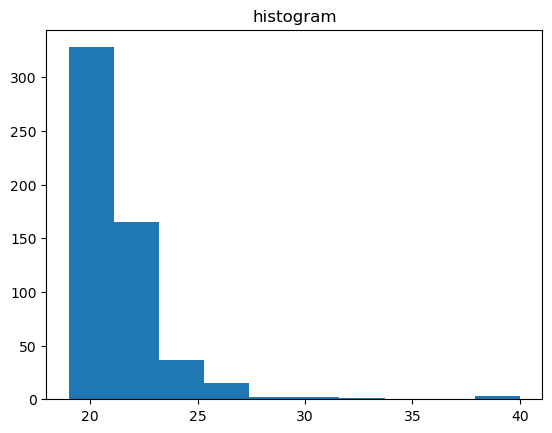

In [21]:
plt.hist(y_pred) 
plt.title("histogram") 
plt.show()

In [22]:
# Try inference on train data
y_pred_train = reg.predict(train_features)
y_pred_train = [np.ceil(y) for y in y_pred_train]

mse = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train) 

print("GradientBoostingRegressor Model")
print(np.unique(y_pred_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on train set: {:.4f}".format(mae))

GradientBoostingRegressor Model
[18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 36.
 37. 38. 39. 40. 41. 42. 44. 45. 47. 49. 50. 51. 53. 56. 57. 60.]
The mean squared error (MSE) on train set: 13.5655
The mean absolute error (MAE) on train set: 2.6621


In [23]:
model_xgb = XGBRegressor()
model_xgb.fit(train_features, y_train)

y_pred2 = model_xgb.predict(val_features)
y_pred2 = [int(round(y)) for y in y_pred2]
mse2 = mean_squared_error(y_val, y_pred2)
mae2 = mean_absolute_error(y_val, y_pred2) 

print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae2))

The mean squared error (MSE) on test set: 30.9222
The mean absolute error (MAE) on test set: 3.7685


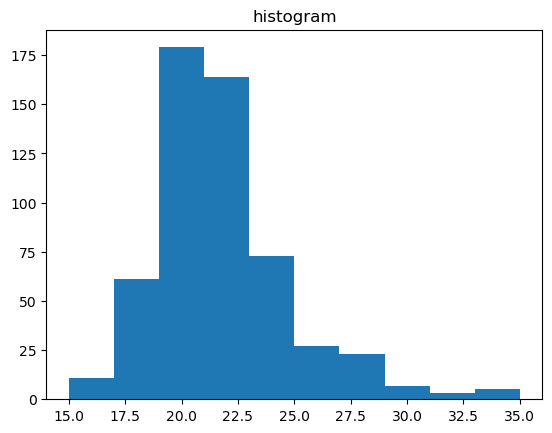

In [24]:
plt.hist(y_pred2) 
plt.title("histogram") 
plt.show()

In [25]:
for i in range(10):
    print(y_pred[i], y_val[i], y_pred2[i])

24 [21] 22
19 [15] 17
20 [20] 22
23 [19] 27
22 [18] 22
21 [21] 21
22 [18] 20
21 [18] 19
21 [18] 21
21 [18] 22


In [26]:
print(np.unique(y_pred), np.unique(y_val))
print(np.unique(y_pred), np.unique(y_train))

[19 20 21 22 23 24 25 26 27 28 30 31 32 39 40] [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 41 45 57]
[19 20 21 22 23 24 25 26 27 28 30 31 32 39 40] [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 40 43 48 54 56 57 65]


In [27]:
y_pred_train2 = model_xgb.predict(train_features)
y_pred_train2 = [int(round(y)) for y in y_pred_train]

mse2 = mean_squared_error(y_train, y_pred_train2)
mae2 = mean_absolute_error(y_train, y_pred_train2) 

print("XGBoost Model")
print(np.unique(y_pred_train))
print("The mean squared error (MSE) on train set: {:.4f}".format(mse2))
print("The mean absolute error (MAE) on train set: {:.4f}".format(mae2))

XGBoost Model
[18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 36.
 37. 38. 39. 40. 41. 42. 44. 45. 47. 49. 50. 51. 53. 56. 57. 60.]
The mean squared error (MSE) on train set: 13.5655
The mean absolute error (MAE) on train set: 2.6621


# Prepare for submission

In [ ]:
def get_csv(y_vals, csv_path, all_file_names):
    df = pd.read_csv(csv_path)
    subjects = df['Subject']
    final_pred = []
    for subject in subjects:
        #we need to get all the y pred of the files that has this subject in its file_name
        file_names = get_audio_filenames(subject)
        indecies = []
        for f in file_names:
            index = all_file_names.index(f)
            indecies.append(index)
        pred = mode(np.array(y_vals[indecies]))[0][0]
        final_pred.append(pred)

    
    df['Age'] = np.array(final_pred)
    df.to_csv('/kaggle/working/submission2.csv', index=False)

    return final_pred

x = get_csv(np.array(y_pred), test_path, test_audio_filenames)


In [ ]:
#this cell is for preparing the results for test data to be submitted to the system with the required format
def get_audio_filenames(subject):
    '''
    Parameter
    ---------
    Subject: int or string represents id of the speaker
    Return
    ------
    list of audio filenames belonging to that speaker
    '''
    audio_filenames = np.array(os.listdir(audios_path))
    return [filename for filename in audio_filenames if filename[5:9] == str(subject)]


class pretrained_wrapper():
    def init(self, model, sr):
        self.model = model
        self.sr = sr

    def predict(self, data):
        prediction = self.model(data)
        prediction = mode(np.round(prediction.numpy()))
        prediction = int(prediction[0][0][0])
        return prediction

class preprocess():
    def init(self, model ,sr):
        self.yamnet_model = model
        self.sr = sr

    def process(self, wav):
        wav = nr.reduce_noise(wav, sr)
        wav = librosa.resample(wav, orig_sr=sr, targetsr=16000)
        _, yamnetembedd, _ = self.yamnet_model(wav)
        return yamnet_embedd

yamnet_preprocess = preprocess(yamnet_model, 48000)
model = pretrained_wrapper(huber_cnn_model, 48000)

def prepare_submission(model, preprocessor,file_path):
    final_pred = []
    df = pd.read_csv(file_path)

    for subject in df['Subject']:
        print(subject)
        test_files = get_audio_filenames(subject)
        predictions = []
        for file in test_files:
            # read audio
            audio, sr = librosa.load(audios_path + file, sr=48000)
            features = preprocessor.process(audio)
            predictions.append(model.predict(features))

        final_pred.append(mode(np.array(predictions)))

    df['Age'] = np.array(final_pred)
    print(len(final_pred))  # 168 + 1 header
    df.to_csv('/kaggle/working/submission.csv')